In [1]:
import numpy as np
import pylab
import cv2
import os

In [2]:
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: d:\workspace\iscat


In [3]:
from src.data_processing.utils import Utils
data_path = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
image_paths,target_paths = Utils.get_data_paths(data_path)

In [4]:
Utils.generate_np_masks(target_paths,seg_method="kmeans")

Creating Masks with KMeans: 100%|██████████| 5/5 [01:16<00:00, 15.25s/it]


In [66]:
cy5_path = "D:\workspace\iscat\dataset\\2024_11_11\Metasurface\Chip_02\Metasurface 01\Brightfield\Captured Cy5.tif"
frame_0 = "D:\workspace\iscat\dataset\\2024_11_11\Metasurface\Chip_02\Metasurface 01\Brightfield\\frame_0.tiff"
comdet_mask_path= "D:\workspace\iscat\dataset\\2024_11_11\Metasurface\Chip_02\Metasurface 01\Brightfield\Captured Cy5_mask.npy"
assert os.path.exists(cy5_path)
assert os.path.exists(frame_0)

uint16
Number of particles: 1457
Average particle size: 16.977


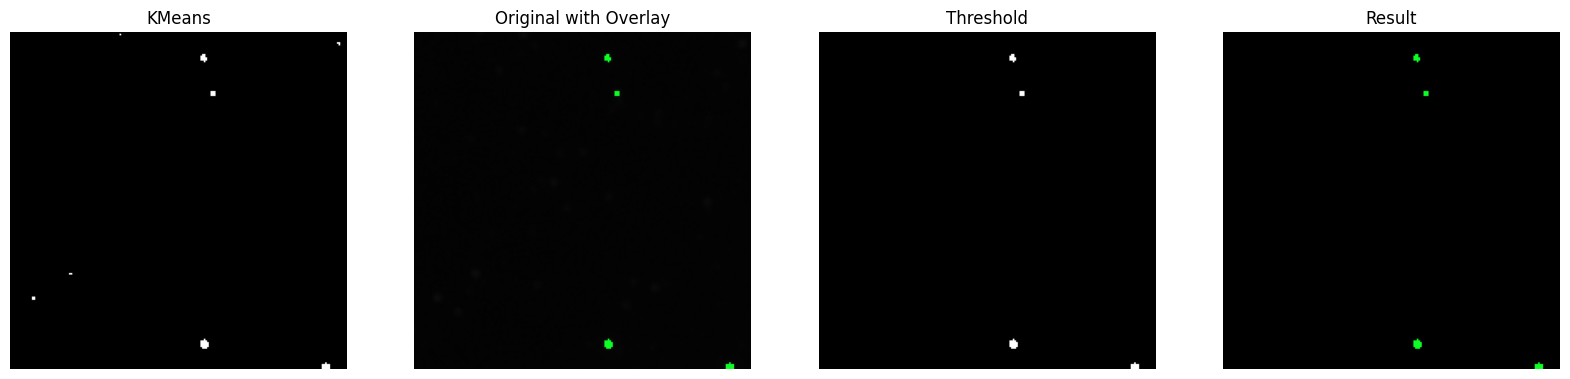

In [97]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Kmeans function
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h * w, 1], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x, y]
            count += 1

    compactness, labels, centers = cv2.kmeans(
        samples,
        clusters,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001),
        rounds,
        cv2.KMEANS_RANDOM_CENTERS
    )

    centers = np.uint16(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load 16-bit grayscale image

image = cv2.imread(cy5_path, cv2.IMREAD_UNCHANGED)
print(image.dtype)
# Normalize the 16-bit image to 8-bit for visualization and processing
image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

original = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)

# Perform kmeans color segmentation, grayscale, Otsu's threshold
kmeans = kmeans_color_quantization(image, clusters=2)
kmeans_normalized = cv2.normalize(kmeans, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
thresh = cv2.threshold(kmeans_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
a= thresh
# Find contours, remove tiny specs using contour area filtering, gather points
points_list = []
size_list = []
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
AREA_THRESHOLD = 3
for c in cnts:
    area = cv2.contourArea(c)
    if area < AREA_THRESHOLD:
        cv2.drawContours(thresh, [c], -1, 0, -1)
    else:
        (x, y), radius = cv2.minEnclosingCircle(c)
        points_list.append((int(x), int(y)))
        size_list.append(area)

# Apply mask onto original image
result = cv2.bitwise_and(original, original, mask=thresh)
result[thresh == 255] = (36, 255, 12)

# Overlay on original
original[thresh == 255] = (36, 255, 12)

# Print number of particles and average size
print("Number of particles: {}".format(len(points_list)))
if size_list:
    print("Average particle size: {:.3f}".format(sum(size_list) / len(size_list)))

# Display images using matplotlib for Jupyter Notebook compatibility
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(kmeans_normalized[400:600,400:600], cmap='gray')
axes[0].set_title('KMeans')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(original[400:600,400:600], cv2.COLOR_BGR2RGB))
axes[1].set_title('Original with Overlay')
axes[1].axis('off')

axes[2].imshow(thresh[400:600,400:600], cmap='gray')
axes[2].set_title('Threshold')
axes[2].axis('off')

axes[3].imshow(cv2.cvtColor(result[400:600,400:600], cv2.COLOR_BGR2RGB))
axes[3].set_title('Result')
axes[3].axis('off')

plt.show()


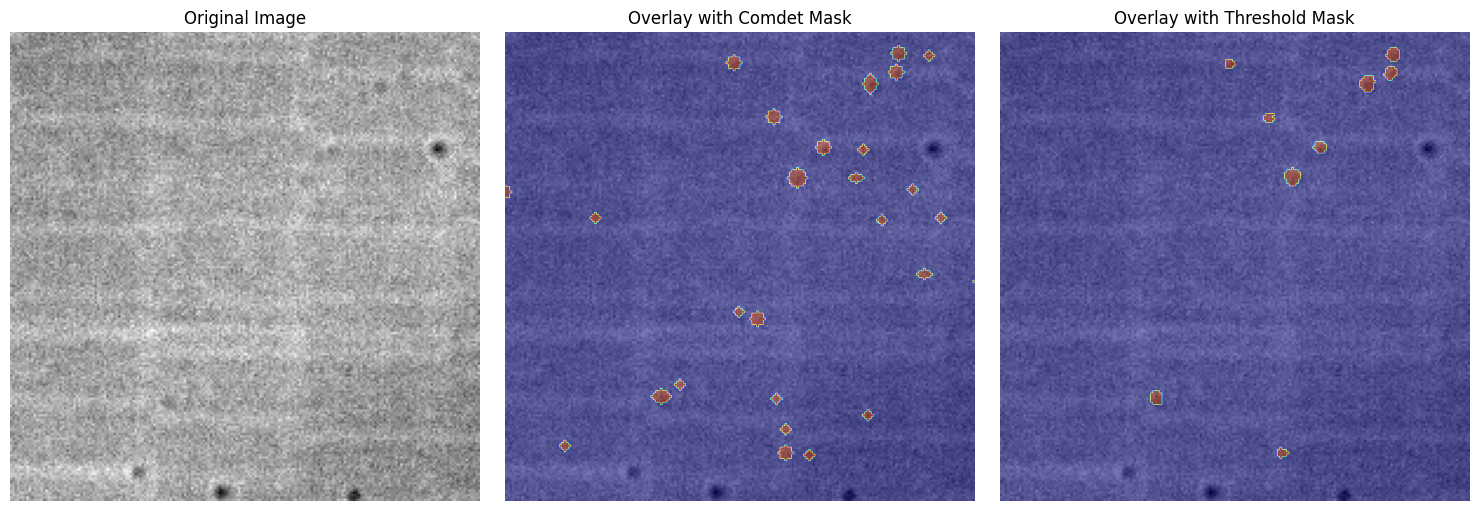

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Load the image and mask
image = np.array(Image.open(frame_0))
comdet_mask = np.load(comdet_mask_path)

# Create a binary threshold mask


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image[600:800,600:800], cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Overlay with comdet mask
axes[1].imshow(image[600:800,600:800], cmap='gray')
axes[1].imshow(comdet_mask[600:800,600:800], cmap='jet', alpha=0.5)  # Overlay mask with transparency
axes[1].set_title("Overlay with Comdet Mask")
axes[1].axis("off")

# Overlay with threshold mask
axes[2].imshow(image[600:800,600:800], cmap='gray')
axes[2].imshow(thresh[600:800,600:800], cmap='jet', alpha=0.5)  # Overlay threshold mask with transparency
axes[2].set_title("Overlay with Threshold Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()
